In [13]:
%%capture
%pip install seaborn

In [14]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns

In [15]:
def load_single_results(data_path):
    with open(data_path, 'r') as f:
        data = json.load(f)
    return data

In [16]:


def get_dice_for_keys(dices: dict, counts: dict,
                      datasets:list = 'all', modalities:list = 'all', tasks:list = 'all'):
    # both dices and counts are nested dictionaries:
    # dataset -> modality -> task : dice score / count of samples found
    all_levels = []
    data_level = defaultdict(list)
    modality_level = defaultdict(list)
    task_level = defaultdict(list)
    for data_key, mod_data in dices.items():
        for modality, task_data in mod_data.items():
            for task, dice in task_data.items():
                if ((datasets == 'all' or data_key in datasets) and
                    (modalities == 'all' or modality in modalities) and
                    (tasks == 'all' or task in tasks)):
                    dice_score = dice
                    count = counts[data_key][modality][task]
                    print('using info from dataset {} modality {} task {}: dice {} count {}'.format(data_key, modality, task, dice_score, count))
                    all_levels.append((dice_score, count))
                    data_level[data_key].append((dice_score, count))
                    modality_level[modality].append((dice_score, count))
                    task_level[task].append((dice_score, count))
    return all_levels, data_level, modality_level, task_level

def compute_avg_dice(dice_count_list: list[tuple]):
    total_dice = 0
    total_count = 0
    for dice, count in dice_count_list:
        total_dice += dice * count
        total_count += count
    return total_dice / total_count

using info from dataset chaos_mrct_42_1 modality CT task spleen: dice 0.0 count 1
using info from dataset chaos_mrct_42_1 modality CT task right kidney: dice 0.0 count 1
using info from dataset chaos_mrct_42_1 modality CT task Liver: dice 0.9635717272758484 count 1
using info from dataset chaos_mrct_42_1 modality MRI task Left kidney: dice 0.0011326860403642058 count 2
using info from dataset chaos_mrct_42_1 modality MRI task Liver: dice 0.3263172209262848 count 5
using info from dataset chaos_mrct_42_1 modality MRI task right kidney: dice 0.022401869297027588 count 2
using info from dataset chaos_mrct_42_1 modality MRI task spleen: dice 0.05140715837478638 count 1
average dice for all levels:  0.20720262315052634
average dice for dataset chaos_mrct_42_1: 0.20720262315052634
average dice for modality CT: 0.32119057575861615
average dice for modality MRI: 0.1730062373680994
average dice for task spleen: 0.02570357918739319
average dice for task right kidney: 0.014934579531351725
average

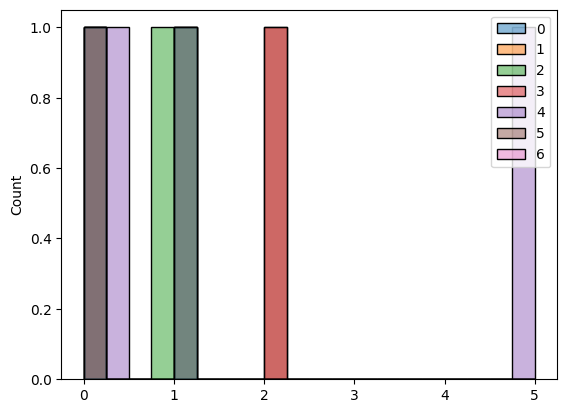

In [18]:
data_path = 'results_12.json'
data = load_single_results(data_path)['12']

all_levels, data_level, modality_level, task_level = get_dice_for_keys(
    data['per_dataset_modality_task_dice'], data['per_dataset_modality_task_counts'])
print('average dice for all levels: ', compute_avg_dice(all_levels))
for dataset, dices in data_level.items():
    print('average dice for dataset {}: {}'.format(dataset, compute_avg_dice(dices)))
for modality, dices in modality_level.items():
    print('average dice for modality {}: {}'.format(modality, compute_avg_dice(dices)))
for task, dices in task_level.items():
    print('average dice for task {}: {}'.format(task, compute_avg_dice(dices)))

sns.histplot(all_levels, bins=20)
plt.show()